# Método dos Elementos Finitos

Universidade Federal Fluminense

Disciplina ministrada pelo Prof. Marco Ferro

<marcoferro@id.uff.br>

Anotações do Aluno Noé de Lima

<noe_lima@id.uff.br>

Primeiro semestre de 2020

\vfill

Esta célula serve para apresentar as equações SageMath no formato \LaTeX e configurar bibliotecas

In [1]:
#%display latex
from numpy import array,linspace,zeros,sinh
from scipy.interpolate import interp1d
from scipy.linalg import solve
import sympy as sym
import matplotlib.pyplot as plt
sym.init_printing(use_latex='mathjax',latex_mode='equation*')
#latex.add_to_preamble('\\usepackage[english,brazil]{babel}')
!uname -a

Linux DESKTOP-CR7O8A2 4.19.104-microsoft-standard #1 SMP Wed Feb 19 06:37:35 UTC 2020 x86_64 x86_64 x86_64 GNU/Linux


\cleardoublepage

\tableofcontents

\cleardoublepage

# Introdução

## Histórico
* Início na década de 50 pelos engenheiros aeronáuticos Turner, Argyris e Associados
* Análise Matricial de Estruturas, PTV
* Anos 60, MEF entendido como um caso particular do Método de Rayleigh-Ritz, logo idealizado a partir de funcionais. Logo o MEF pôde ser aplicado a problemas de fluidos, meios porosos, termodinâmica, eletromagnetismo, dentre outros.
* No final dos anos 60, foi comprovado que o MEF pode também ser considerado como um caso particular do Método de Galerkin, dispensando a necessidade de um funcional.
* Nos anos 70 o MEF foi identificado como um caso particular do MRP - Método dos Resíduos Ponderados. Expansão do MEF com computadores mais modernos e o advento de linguagens de baixo nível (FORTRAN e BASIC). O FORTRAN foi criado no meio da década de 1950, mas começou a crescer com o FORTRAN IV (1962), tendo um grande avanço com o FORTRAN 77.
* Nos anos 80 houve a disponibilidade e a explosão dos "microcomputadores" e vários grupos de pesquisa e desenvolvimento do MEF foram criados ao redor do planeta.
* Dos anos 90 até os dias atuais, vários programas comerciais foram disponibilizados, alguns considerando pré e pós processamento e a computação paralela.
* Para o dimensionamento de estruturas, no Brasil, os mais usados são o TQS e o EBERICK.
* Além disso, diversas linguagens são usadas para programação do MEF, como FORTRAN, C++, Matlab, dentre outras e, mais recentemente, Python.

# Método Numéricos

(FAZER DIAGRAMA E INCLUIR AQUI)

Segue abaixo a importação das bibliotecas que serão utilizadas.

## Exemplo

Considere a seguinte equação diferencial e suas condições de contorno:
\begin{equation}
    \left[\begin{matrix}
        \frac{d^{2}u}{dx^{2}}-u=0; & 0 \leqslant x \leqslant 1 \\
        u\left( 0\right)=0 & u\left( 1\right)=1
    \end{matrix}\right.
\end{equation}

O código em SageMath a seguir coloca esta equação em uma variável:

In [2]:
x = sym.symbols('x') # Cria a variável independente x
u = sym.Function('u') # Cria a variável dependente u(x)
eqn = sym.Eq(sym.diff(u(x),x,2) - u(x), 0); # Equação Diferencial $\frac{d^{2}u}{dx^{2}}-u=0$
display(eqn)

          2          
         d           
-u(x) + ───(u(x)) = 0
          2          
        dx           

O código a seguir encontra a solução analítica:

In [3]:
analitc = sym.dsolve(eqn,u(x),ics={u(0):0,u(1):1}).simplify() # Resolve a equação para a variável u(x), passando pelos pontos (0,0) e (1,1), e simplifica
display(analitc)

       sinh(x)
u(x) = ───────
       sinh(1)

In [4]:
u.subs(x,0)

ValueError: 
When a single argument is passed to subs it should be a dictionary of
old: new pairs or an iterable of (old, new) tuples.

In [5]:
u = sym.sinh(x)/sym.sinh(1)

Rearrumando, a solução pode ser reescrita na forma:
\begin{equation}
    u\left( x\right) = \frac{e^{x}-e^{-x}}{e-e^{-1}}
\end{equation}

Este exemplo será utilizado nas seções a seguir.

Abaixo, temos o gráfico desta solução dentro do domínio $0 \leqslant x \leqslant 1$.

In [6]:
xd = linspace(0.,1.,11)

In [24]:
def yexata(x):
    return sinh(x)/sinh(1)

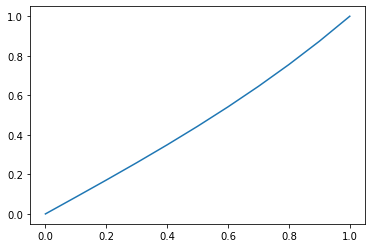

In [25]:
exata = plt.plot(xd,yexata(xd)) # Plota a solução u(x) no intervalo (0 < x < 1)
#exata.show()

### Vetor $x$ (Definição do Domínio)

Este código define o domínio $x$ para o exemplo, e será utilizado como entrada nos demais códigos.

Neste exemplo, o domínio é $0 \leqslant x \leqslant 1$, discretizado em intervalos de $0,1$.

## MRP - Método dos Resíduos Ponderados

Considere uma equação diferencial em $u(x)$ como mostrado a seguir, e suas condições de contorno.
\begin{equation}
    \left[\begin{matrix}
        L\left[ u\left( x\right) \right] = f\left( x\right); & a \leqslant x \leqslant b \\
        u\left(a \right) = u_{a}; & u\left( b\right) = u_{b}
    \end{matrix}\right.
\end{equation}(1)

A solução aproximada de $u(x)$ é $\bar{u}(x)$ e possui a seguinte forma:
\begin{equation}
    \bar{u}\left( x\right) = \phi_{0}\left( x\right) + \sum_{i=1}^{n}{a_{i}\phi_{i}\left( x\right)}
\end{equation}

Onde $\phi_{i}$ são as funções de aproximação (a princípio arbitrárias) e $a_{i}$ são coeficientes.

Substituindo $\bar{u}$ em (1), tem-se:
\begin{equation}
    L\left[ \bar{u}\left( x\right)\right] - f\left( x\right) = R
\end{equation}

Onde $R$ é denominado Resíduo.

O MRP consiste em ponderar o Resíduo, de modo que a integral ao longo do domínio seja nula. Logo,
\begin{equation}
    \int_{D}{W_{i}R}dv = 0
\end{equation}

(SRP - Sentença de Resíduos Ponderados)

Sendo,

* $W_{i}\rightarrow$ as funções de ponderação;

* $D\rightarrow$ o domínio e;

* $dv\rightarrow$ os diferenciais relativos ao domínio considerado.

### Analogia

É como se houvesse uma compensação de áreas situadas entre $y$ e $\bar{y}$, com ponderação.

(INCLUIR GRÁFICO)

## Subdomínio (MVF - Método dos Volumes Finitos)

### Função de Ponderação

\begin{equation}
    W_{i}\left( x\right) =
    \left[\begin{matrix}
        1 & x \in D\\
        0 & x \notin D
    \end{matrix}\right.
\end{equation}

### Exemplo

Considere a seguinte equação diferencial e suas condições de contorno para a qual obtivemos a Solução Exata.
\begin{equation*}
    \left[\begin{matrix}
        \frac{d^{2}u}{dx^{2}}-u=0; & 0 \leqslant x \leqslant 1 \\
        u\left( 0\right)=0 & u\left( 1\right)=1
    \end{matrix}\right.
\end{equation*}

A função de aproximação escolhida por simplicidade é um polinômio da forma $x^{i}$. Logo,
\begin{equation}
    \bar{u}\left( x\right) = \sum_{i=0}^{n+1}{C_{i}x^{i}}
\end{equation}

Para que as condições de contorno sejam atendidas, temos:
\begin{equation*}
    \bar{u}\left(0\right) = \sum_{i=0}^{n+1}{C_{i}x^{i}} = 0 = \sum_{i=0}^{n+1}{C_{i}0^{i}}
\end{equation*}

Mas,
\begin{equation*}
    0^{i} =
    \left[\begin{matrix}
        1 & i = 0 \\
        0 & i \neq 0
    \end{matrix}\right.
\end{equation*}

Logo,
\begin{equation*}
    \sum_{i=0}^{n+1}{C_{i}0^{i}} =
    C_{0}0^{0} + \sum_{i=1}^{n+1}{C_{i}0^{i}} =
    C_{0} + \sum_{i=1}^{n+1}{C_{i}0} = 0
    \therefore C_{0} = 0
\end{equation*}

Bem como,

\begin{equation*}
    \bar{u}\left(1\right) = 1 \rightarrow
    \sum_{i=1}^{n+1}{C_{i}1^{i}} =
    \sum_{i=1}^{n+1}{C_{i}1} = 1 \therefore
    \sum_{i=1}^{n+1}{C_{i}} = 1
\end{equation*}

Logo,
\begin{equation*}
    \bar{u}\left(x\right) =
    \sum_{i=1}^{n+1}{C_{i}x^{i}}
\end{equation*}

Utilizando $n=1$,

\begin{equation*}
    \bar{u}\left(x\right) = C_{1}x + C_{2}x^{2}
\end{equation*}

Com $C_{1}+C_{2}=1$.

Assim, tem-se:

\begin{equation*}
    R = \frac{d^{2}\bar{u}}{dx^{2}}-\bar{u} = 2C_{2}-C_{1}x-C_{2}x^{2}
\end{equation*}

Utilizando o fator de ponderação $W_{i}=1$, tem-se:
\begin{equation*}
    \int_{0}^{1}{1\left[2C_{2}-C_{1}x-C_{2}x^{2}\right]}dx =
    \left[2C_{2}x-C_{1}\frac{x^{2}}{2}-C_{2}\frac{x^{3}}{3}\right]_{0}^{1} =
    2C_{2}-\frac{C_{1}}{2}-\frac{C_{2}}{3} = 0
\end{equation*}

\begin{equation*}
    \left[\begin{matrix}
        -\frac{1}{2}C_{1} + \frac{5}{3}C_{2} & = & 0 \\
        C_{1} + C_{2} & = & 1
    \end{matrix}\right.
\end{equation*}

A solução deste sistema é:
\begin{equation*}
    \left[\begin{matrix}
        C_{1} & = & \frac{10}{13} \\
        C_{2} & = & \frac{3}{13}
    \end{matrix}\right.
\end{equation*}

Logo, tem-se
\begin{equation*}
    \bar{u}\left(x\right) = \frac{10}{13}x + \frac{3}{13}x^{2}
\end{equation*}

Somando-se e subtraindo-se $\frac{3}{13}x$, obtém-se
\begin{equation}
    \bar{u}\left(x\right) = x + \frac{3}{13}\left(x^{2}-x\right)
\end{equation}

### Implementação do Subdomínio

Abaixo, temos a implementação do MVF e o gráfico comparando com a solução exata.

In [9]:
def ysubdominio(x):
    return x+3/13*x*(x-1)

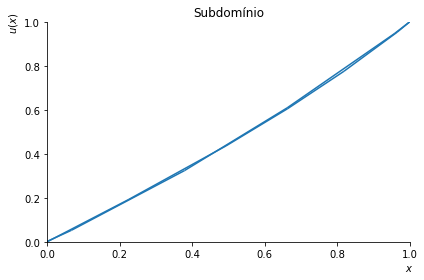

In [10]:
subdominio = sym.plot(x+3/13*x*(x-1),u,xlim=[0,1],ylim=[0,1],xlabel='$x$',ylabel='$u(x)$',title='Subdomínio',show=False) # Plota a solução u(x) no intervalo (0 < x < 1)
subdominio.show()

## Galerkin

No Método de Galerkin, a Função de Ponderação é igual a Função de Aproximação. Logo,

\begin{equation}
    \begin{matrix}
        W_{i}\left(x\right) = \phi_{i}\left(x\right) & \left( i=1,2,3,\dots ,n\right)
    \end{matrix}
\end{equation}

E a SRP - Sentença de Resíduos Ponderados, torna-se:
\begin{equation}
    \int_{D}{\phi_{i}R}dv = 0
\end{equation}

### Exemplo

Considere a mesma equação diferencial e as mesmas condições de contorno do exemplo anterior.
\begin{equation*}
    \left[\begin{matrix}
        \frac{d^{2}u}{dx^{2}}-u=0; & 0 \leqslant x \leqslant 1 \\
        u\left( 0\right)=0 & u\left( 1\right)=1
    \end{matrix}\right.
\end{equation*}

Adota-se $W_{i}\left(x\right) = \phi_{i}\left(x\right) = x(x-1)$, com $n=1$.

A SRP torna-se
\begin{equation*}
    \int_{0}^{1}{W_{i}R}dx =
    \int_{0}^{1}{W_{i}\left(\frac{d^{2}\bar{u}}{dx^{2}}-\bar{u}\right)}dx =
\end{equation*}

\begin{equation*}
    \left[W_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} - \int_{0}^{1}{\left(\frac{dW_{i}}{dx}\frac{d\bar{u}}{dx}\right)}dx - \int_{0}^{1}{W_{i}\bar{u}}dx = 0
\end{equation*}

Lembrando que o resultado acima sai a partir da integração por partes, onde,
\begin{equation}
    \int{u}dv = uv-\int{v}du
\end{equation}

E, portanto,
\begin{equation*}
    \int{W_{i}\frac{d^{2}\bar{u}}{dx^{2}}}dx =
    \left[W_{i}\frac{d\bar{u}}{dx}\right] - \int{\left(\frac{dW_{i}}{dx}\frac{d\bar{u}}{dx}\right)}dx
\end{equation*}

Porém,
\begin{equation*}
    \left[W_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} = 0
\end{equation*}

Pois $W = x(x-1) = 0$ para $x=0$ e $x=1$. Logo,
\begin{equation*}
    \begin{matrix}
        -\int_{0}^{1}{\left(\frac{d\phi_{i}}{dx}\frac{d\bar{u}}{dx}\right)}dx - \int_{0}^{1}{\phi_{i}\bar{u}}dx = 0\\
        -\int_{0}^{1}{\left(2x-1\right)\left(C_{1}+2C_{2}x\right)}dx - \int_{0}^{1}{\left(x^{2}-x\right)\left(C_{1}x+C_{2}x^{2}\right)}dx = 0 \\
        \int_{0}^{1}{\left(2C_{1}x + 4C_{2}x^{2} - C_{1} - 2C_{2}x\right)}dx + \\
        \int_{0}^{1}{\left(C_{1}x^{3} + C_{2}x^{4} - C_{1}x^{2} - C_{2}x^{3}\right)}dx = 0 \\
        \left[\frac{2}{2}C_{1}x^{2} + \frac{4}{3}C_{2}x^{3} - C_{1}x - \frac{2}{2}C_{2}x^{2}\right]_{0}^{1} + \\
        \left[\frac{1}{4}C_{1}x^{4} + \frac{1}{5}C_{2}x^{5} - \frac{1}{3}C_{1}x^{3} - \frac{1}{4}C_{2}x^{4}\right]_{0}^{1} = 0
    \end{matrix}
\end{equation*}

Logo, simplificando,
\begin{equation*}
    \begin{matrix}
        \not{C_{1}} + \frac{4}{3}C_{2} - \not{C_{1}} - C_{2} + \frac{1}{4}C_{1} + \frac{1}{5}C_{2} - \frac{1}{3}C_{1} - \frac{1}{4}C_{2} = \\
        \left(\frac{1}{4}-\frac{1}{3}\right)C_{1} + \left(\frac{4}{3}-1+\frac{1}{5}-\frac{1}{4}\right)C_{2} = 0 \\
        \left(\frac{3-4}{12}\right)C_{1} + \left(\frac{80-60+12-15}{60}\right)C_{2} = 0 \\
        -\frac{1}{12}C_{1}\left(\frac{5}{5}\right)+\frac{17}{60}C_{2} = 0
    \end{matrix}
\end{equation*}

Portanto,
\begin{equation*}
    \left[\begin{matrix}
        -5C_{1} & + & 17C_{2} & = & 0 \\
        C_{1} & + & C_{2} & = & 0
    \end{matrix}\right.
\end{equation*}

A solução desse sistema é:
\begin{equation*}
    \left[\begin{matrix}
        C_{1} & = & \frac{17}{22} \\
        C_{2} & = & \frac{5}{22}
    \end{matrix}\right.
\end{equation*}

Assim,
\begin{equation}
    \bar{u}\left(x\right) = x + \frac{5}{22}x\left(x-1\right)
\end{equation}

In [11]:
def ygalerkin(x):
    return x+5/22*x*(x-1)

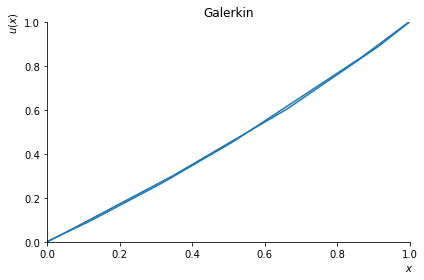

In [12]:
galerkin = sym.plot(x+5/22*x*(x-1),u,xlim=[0,1],ylim=[0,1],xlabel='$x$',ylabel='$u(x)$',title='Galerkin',show=False) # Plota a solução u(x) no intervalo (0 < x < 1)
galerkin.show()

## Rayleigh-Ritz

É utilizado quando existe um Funcinoal equivalente à uma equação diferencial.

* PTV - Princípio dos Trabalhos Virtuais

* EPM - Energia Potencial Mínima

Considere $\Pi(u)$ o funcional equivalente à equação diferencial
\begin{equation*}
    \frac{d^{2}u}{dx^{2}} - u = 0
\end{equation*}

O MRR - Método de Rayleigh-Ritz considera que a solução aproximada $\bar{u}(x)$ é uma combinação linear de funções de aproximação $\phi_{i}(x)$, ou seja,
\begin{equation}
    \bar{u}\left(x\right) = \sum_{i=1}^{n}{a_{i}\phi_{i}\left(x\right)}
\end{equation}

Sendo $a_{i}, (i=1.2.\dots,n)$ coeficientes arbitrários e $\phi_{i}(x)$ devem ser escolhidos para atenderem as condições de contorno:
\begin{equation*}
    \left[\begin{matrix}
        \sum_{i=1}^{n}{a_{i}\phi_{i}\left(a\right)} & = & u_{a} \\
        \sum_{i=1}^{n}{a_{i}\phi_{i}\left(b\right)} & = & u_{b}
    \end{matrix}\right.
\end{equation*}

A solução aproximada $\bar{y}$ deve tornar o Funcional "estacionário" em relação às constantes $a_{i}$, ou seja, nulo. Logo,
\begin{equation*}
    \begin{matrix}
        \frac{\partial \Pi}{\partial  a_{i}} = 0; & \left(i=1,2,\dots ,n\right)
    \end{matrix}
\end{equation*}

O Funcional $\Pi$ da equação diferencial $\frac{d^{2}u}{dx^{2}}-u=0$ vale
\begin{equation*}
    \Pi\left(u\right) = \int_{0}^{1}{\left[\frac{1}{2}\left(\frac{du}{dx}\right)^{2}+\frac{1}{2}u^{2}\right]}dx
\end{equation*}

Supondo $\bar{u}=x+ax(x+1)$,
\begin{equation*}
    \begin{matrix}
        \Pi\left(\bar{u}\right) = \int_{0}^{1}{\left[\frac{1}{2}\left(1+a\left(2x-1\right)\right)^{2}+\frac{1}{2}\left(x+a\left(x^{2}-x\right)\right)^{2}\right]}dx \\
        \Pi\left(\bar{u}\right) = \frac{2}{3} - \frac{a}{12} + \frac{a^{2}}{3}
    \end{matrix}
\end{equation*}

Como
\begin{equation*}
    \begin{matrix}
        \frac{\partial\Pi\left(\bar{u}\right)}{\partial a} = 0 \therefore -\frac{1}{12} + \frac{2}{3}a = 0 \\
        a = \frac{1}{8}
    \end{matrix}
\end{equation*}

Portanto,
\begin{equation}
    \bar{u}\left(x\right) = x + \frac{1}{8}x\left(x-1\right)
\end{equation}

### Implementação do Método de Rayleigh-Ritz

A seguir, a implementação do Método de Rayleigh-Ritz, bem como o gráfico de comparação com a solução exata.

In [13]:
def yRR (x):
    return x+1/8*x*(x-1)

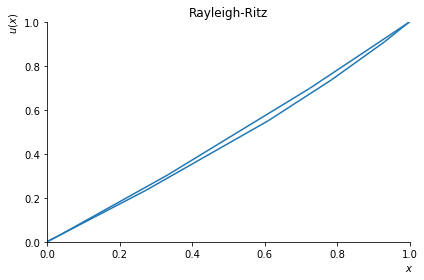

In [14]:
RR = sym.plot(x+1/8*x*(x-1),u,xlim=[0,1],ylim=[0,1],xlabel='$x$',ylabel='$u(x)$',title='Rayleigh-Ritz',show=False) # Plota a solução u(x) no intervalo (0 < x < 1)
RR.show()

# MEF - Método dos Elementos Finitos

O Método dos Elementos Finitos pode ser entendido como derivado do Método de Galerkin, onde, na SRP (Sentença de Resíduos Ponderados), $W_{i}=\phi_{i}$, considera-se o domínio $1-D$ (unidimensional) dividido em segmentos ou elementos, sendo os seus pontos extremos denominados nós.

(INSERIR IMAGEM)

Tem-se que:
\begin{equation}
    \bar{u} = \sum_{i=1}^{n+1}{u_{i}N_{i}\left(x\right)}
\end{equation}

No segmento $e$, temos:
\begin{equation}
    h_{e} = x_{e}^{\left(2\right)} - x_{e}^{\left(1\right)}
\end{equation}

E, tem-se que
\begin{equation}
    \bar{u}\left(x\right) = \sum_{i=1}^{n+1}{u_{i}N_{i}\left(x\right)}
\end{equation}

Assim, localmente,
\begin{equation*}
    N_{1}\left(e\right) = \frac{x_{e}^{\left(2\right)}-x}{x_{e}^{\left(2\right)}-x_{e}^{\left(1\right)}} =
    \frac{x_{e}^{\left(2\right)}-x_{e}^{\left(1\right)}-x_{e}}{x_{e}^{\left(2\right)}-x_{e}^{\left(1\right)}}
\end{equation*}

\begin{equation*}
    \begin{matrix}
        N_{1}\left(e\right) = \frac{h_{e}-x_{e}}{h_{e}} &
        \left[\begin{matrix}
            N_{1}\left(x_{e}\right) = 1 \\
            N_{1}\left(h_{e}\right) = 0
        \end{matrix}\right.
    \end{matrix}
\end{equation*}

\begin{equation*}
    N_{2}\left(e\right) = \frac{x-x_{e}^{\left(1\right)}}{x_{e}^{\left(2\right)}-x_{e}^{\left(1\right)}}
\end{equation*}

\begin{equation*}
    \begin{matrix}
        N_{1}\left(e\right) = \frac{x_{e}}{h_{e}} &
        \left[\begin{matrix}
            N_{2}\left(x_{e}\right) = 0 \\
            N_{2}\left(h_{e}\right) = 1
        \end{matrix}\right.
    \end{matrix}
\end{equation*}

Usando o Método de Galerkin na SRP, temos:
\begin{equation}
    \int_{0}^{1}{N_{i}R}dx = 0
\end{equation}

Ou,
\begin{equation*}
    \begin{matrix}
        \int_{0}^{1}{N_{i}\left(\frac{d^{2}\bar{u}}{dx^{2}}-\bar{u}\right)}dx = \\
        \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} - \int_{0}^{1}{\left(\frac{dN_{i}}{dx}\frac{d\bar{u}}{dx}+N_{i}\bar{u}\right)}dx = 0
    \end{matrix}
\end{equation*}

Logo, lembrando que
\begin{equation*}
    \bar{u}\left(x\right) = \sum_{i=1}^{n+1}{u_{i}N_{i}\left(x\right)}
\end{equation*}

Obtém-se
\begin{equation*}
    \begin{matrix}
        \sum_{j=1}^{n+1}{\int_{0}^{1}{\left[\left(\frac{dN_{i}}{dx}\frac{dN_{j}}{dx}\right)u_{j} + \left(N_{i}N_{j}\right)u_{j}\right]}dx} -
        \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} = 0 \\
        \therefore \\
        \sum_{j=1}^{n+1}{\int_{0}^{1}{\left(\frac{dN_{i}}{dx}\frac{dN_{j}}{dx} + N_{i}N_{j}\right)}u_{j}dx} -
        \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1} = 0
    \end{matrix}
\end{equation*}

A partir da equação acima, define-se a <b><i>Matriz de Rigidez</i></b> $K$.

### Matriz de Rigidez e Matriz de Força (ou Carregamento) Nodal

\begin{equation}
    K_{ij} \equiv \int_{0}^{1}{\left(\frac{dN_{i}}{dx}\frac{dN_{j}}{dx} + N_{i}N_{j}\right)}dx
\end{equation}

Onde $\left(i,j\right)\geqslant 1$;

\begin{equation}
    f_{i} \equiv \left[N_{i}\frac{d\bar{u}}{dx}\right]_{0}^{1}
\end{equation}

Onde $i \leqslant n+1$

## MEF com 1 Elemento

Aplicando o MEF ao exemplo utilizado até aqui:
\begin{equation*}
    \frac{d^{2}u}{dx^{2}} - u = 0
\end{equation*}

Subdividindo o domínio em um segmento (ou seja, sen divisão interna), temos:

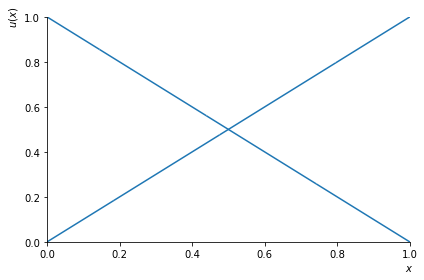

In [15]:
fig = sym.plot(1-x,x,xlim=[0,1],ylim=[0,1],xlabel='$x$',ylabel='$u(x)$',show=False)
fig.show()

Onde,

* $N_{1}\left(x\right) = \frac{1-x}{1} = 1-x$

* $N_{2}\left(x\right) = \frac{x}{1} = x$

Logo,
\begin{equation*}
    K_{ij} = \int_{0}^{1}{\frac{dN_{i}}{dx}\frac{dN_{j}}{dx}+N_{i}N_{j}}dx
\end{equation*}

Se $i=j$,
\begin{equation*}
    \begin{matrix}
        K_{11} = K_{22} = \int_{0}^{1}{\left[\left(-1\right)\times\left(-1\right)+\left(1-x\right)^{2}\right]}dx = \\
        \int_{0}^{1}{\left(1+1-2x+x^{2}\right)}dx = \int_{0}^{1}{\left(x^{2}-2x+2\right)}dx = \\
        \left[\frac{x^{3}}{3} - \frac{\not{2}x^{2}}{\not{2}} + 2x\right]_{0}^{1} = \frac{1}{3}-1+2 = \frac{4}{3}
    \end{matrix}
\end{equation*}

Ou, alternativamente,
\begin{equation*}
    \begin{matrix}
        K_{11} = K_{22} = \int_{0}^{1}{\left[\left(1\right)\times\left(1\right)+\left(x\right)^{2}\right]}dx = \int_{0}^{1}{\left(1+x\right)^{2}}dx = \\
        \left[x + \frac{x^{3}}{3}\right]_{0}^{1} = 1 + \frac{1}{3} = \frac{4}{3}
    \end{matrix}
\end{equation*}

Para $i \ne j$, temos:
\begin{equation*}
    \begin{matrix}
        K_{12} = K_{21} = \int_{0}^{1}{\left[\left(-1\right)\times\left(1\right)+\left(1-x\right)x\right]}dx = \\
        \int_{0}^{1}{\left(-1+x-x^{2}\right)}dx = \left[-x + \frac{x^{2}}{2} - \frac{x^{3}}{3}\right]_{0}^{1} = \\
        -\frac{1}{1} + \frac{1}{2} - \frac{1}{3} = \frac{-6+3-2}{6} = -\frac{5}{6}
    \end{matrix}
\end{equation*}

Portanto, temos:
\begin{equation*}
    \mathbf{K} = 
    \left[\begin{matrix}
        \frac{4}{3} & -\frac{5}{6} \\
        -\frac{5}{6} & \frac{4}{3}
    \end{matrix}\right]
\end{equation*}

Tem-se, também, que $\mathbf{K}\bar{u} = \vec{f}$, Ou,
\begin{equation*}
    \left[\begin{matrix}
        \frac{4}{3} & -\frac{5}{6} \\
        -\frac{5}{6} & \frac{4}{3}
    \end{matrix}\right]
    \left[\begin{matrix}
        u_{1} \\
        u_{2}
    \end{matrix}\right] =
    \left[\begin{matrix}
        -\frac{d\bar{u}\left(0\right)}{dx} \\
        -\frac{d\bar{u}\left(1\right)}{dx} \\
    \end{matrix}\right]
\end{equation*}

Sabe-se, ainda, que:
\begin{equation*}
    \left[\begin{matrix}
        u_{1}\left(0\right) = 0 \\
        u_{1}\left(1\right) = 1
    \end{matrix}\right.
\end{equation*}

Assim,
\begin{equation*}
    \left[\begin{matrix}
        \frac{4}{3} & -\frac{5}{6} \\
        -\frac{5}{6} & \frac{4}{3}
    \end{matrix}\right]
    \left[\begin{matrix}
        0 \\
        1
    \end{matrix}\right] =
    \left[\begin{matrix}
        -\frac{d\bar{u}\left(0\right)}{dx} \\
        -\frac{d\bar{u}\left(1\right)}{dx} \\
    \end{matrix}\right]
\end{equation*}

Resolvendo este sistema, obtém-se:
\begin{equation*}
    \left[\begin{matrix}
        \frac{d\bar{u}\left(0\right)}{dx} & = &  \frac{5}{6} \\
        \frac{d\bar{u}\left(1\right)}{dx} & = & -\frac{4}{3} \\
    \end{matrix}\right.
\end{equation*}

In [16]:
def yFEM1E (x):
    return x

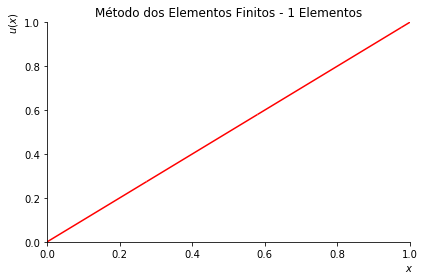

In [17]:
MEF1 = sym.plot(x,line_color='red',xlim=[0,1],ylim=[0,1],xlabel='$x$',ylabel='$u(x)$',title='Método dos Elementos Finitos - 1 Elementos',show=False) # Plota a solução u(x) no intervalo (0 < x < 1)
MEF1.show()

## MEF com 2 Elementos

DESENVOLVER...

## MEF com 3 Elementos

Agora veremos o mesmo exemplo aplicando o MEF com 3 Elementos.
\begin{equation*}
    \bar{u}\left(x\right) = \sum_{i=1}^{4}{u_{i}N_{i}}
\end{equation*}

Dividindo o domínio em 3 segmentos, temos 4 nós igualmente espaçados. São eles: $N_{1}\rightarrow(x=0)$, $N_{2}\rightarrow(x=\frac{1}{3})$, $N_{3}\rightarrow(x=\frac{2}{3})$ e $N_{4}\rightarrow(x=1)$.

Localmente (no elemento), temos:
\begin{equation*}
    \left[\begin{matrix}
        N_{1}^{e} & = & \frac{h_{e}-x}{h_{e}} \\
        N_{2}^{e} & = & \frac{x}{h_{e}}
    \end{matrix}\right.
\end{equation*}

Onde $h_{e} = \frac{1}{3}$.

Portanto,
\begin{equation*}
    \left[\begin{matrix}
        N_{1}^{e} & = & \frac{\frac{1}{3}-x}{\frac{1}{3}} & = & 1-3x \\
        N_{2}^{e} & = & \frac{x}{\frac{1}{3}} & = & 3x
    \end{matrix}\right.
\end{equation*}

Assim,
\begin{equation*}
    K_{ij} = \int_{0}^{\frac{1}{3}}{\left[\left(\frac{dN_{i}}{dx}\frac{dN_{j}}{dx}\right) + N_{i}N_{j}\right]}dx
\end{equation*}

\begin{equation*}
    f_{i} = \left[N_{i}\frac{d\bar{u}}{dx}\right] \therefore \vec{f} =
    \left[\begin{matrix}
        -\frac{d\bar{u}\left(0\right)}{dx} \\
        0 \\
        0 \\
        -\frac{d\bar{u}\left(1\right)}{dx}
    \end{matrix}\right]
\end{equation*}

Ressaltando que só existe $f_{i}$ em $N_{1}$ e $N_{4}$.

Assim,
\begin{equation*}
    \mathbf{K} =
    \left[\begin{matrix}
        \frac{28}{9} & -\frac{53}{18} \\
        -\frac{53}{18} & \frac{28}{9}
    \end{matrix}\right]
\end{equation*}

Considerar que o nó $N_{2}$ é influenciado pelos elementos $N_{1}$ e $N_{2}$ e o nó $N_{3}$ pelos elementos $N_{2}$ e $N_{3}$.

As condições de contorno de Dirichlet DEVEM ser atendidas, ou seja, $u_{1}=0$ e $u_{4}=1$. Logo, as incógnitas serão:
\begin{equation*}
    \begin{matrix}
        \frac{du\left(0\right)}{dx}, & u_{2}, & u_{3}, & \frac{du\left(1\right)}{dx}
    \end{matrix}
\end{equation*}

In [18]:
xfemtres=[0.,0.333,0.667,1.]
yfemtres=[0.,0.2885,0.6098,1.]
ylin=interp1d(xfemtres,yfemtres,kind='linear')(xd)

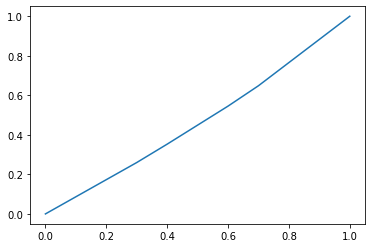

In [19]:
MEF3 = plt.plot(xd,ylin) # Plota a solução u(x) no intervalo (0 < x < 1)
plt.show()

## MEF com $n$ Elementos

DESENVOLVER

## Implementação do MEF com n Elementos

In [20]:
def mefn(a, b, ua, ub, n):
    x = array(linspace(a,b,n+1)) # Domínio
    # f = array([linspace(0,0,n+1)]).transpose() # Vetor de força nodal (matriz coluna de zeros)
    K = zeros([(n+1),(n+1)]) # Matriz de Rigidez Global
    he = (b-a)/n # Subdomínio
    for i in range(n): # Montagem da Matriz de Rigidez Global
        K[i,i] += (1/he)+(he/3)
        K[i,i+1] += (-1/he)+(he/6)
        K[i+1,i] += (-1/he)+(he/6)
        K[i+1,i+1] += (1/he)+(he/3)
    # Rearranjo do Sistema
    # f -= ua*K[:,0] + ub*K[:,n] # Implementação alternativa com inicialização de f
    f = - ua*K[:,0] - ub*K[:,n]
    K[:,0] *= 0
    K[:,n] *= 0
    K[0,0] = 1.
    K[n,n] = -1.
    # Solução do Sistema
    u = solve(K,f) # Vetor de solução
    u[0],u[n] = ua,ub # Substituição de du(a)/dx e du(b)/dx por u(a) e u(b)
    return x, u
out = mefn(0.,1.,0.,1.,100)
ymefn=interp1d(out[0],out[1],kind='linear')(xd)

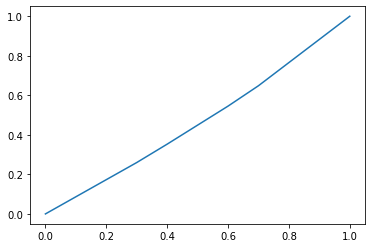

In [21]:
MEFn = plt.plot(xd,ylin) # Plota a solução u(x) no intervalo (0 < x < 1)
plt.show()

# Comparação das Soluções

In [22]:
compara = sym.plot(xlim=[0,1],ylim=[0,1],title='Comparação Entre os Métodos',show=False)
compara.append(exata[0])
compara.append(subdominio[0])
compara.append(galerkin[0])
compara.append(RR[0])
compara.append(MEF1[0])
#compara.append(MEF3[0])
#compara.append(MEFn[0])
compara.show()

NameError: name 'exata' is not defined

# PTV - Princípio dos Trabalhos Virtuais

Considere a barra de treliça sujeita a uma força de tração $f$, com área de seção transversal $A$, comprimento $l$ e Módulo de Elasticidade $E$.

(INSERIR FIGURA)

A medida que a treliça está sendo carregada, ocorre um alongamento até a posição de equilíbrio.

A curva Tensão $\times$ Deformação é mostrada a seguir:

(INSERIR FIGURA)

(INSERIR DETALHE)

No detalhe, temos:
\begin{equation*}
    \Delta U_{0m} = Area_{\square_{ABDE}} + Area_{curva-AB}
\end{equation*}

Assim,
\begin{equation}
    \begin{matrix}
        \Delta U_{0m} & = & \underbrace{\sigma_{m}\delta\epsilon_{m}} & + & \underbrace{\frac{1}{2}\delta\sigma_{m}\delta\epsilon_{m}} & + & erro_{U_{0m}} \\
                      &   & \delta U_{0m}^{(1)}                       &   & \delta U_{0m}^{(2)}                                        &   &
    \end{matrix}
\end{equation}

\begin{equation}
    \Delta U_{0m} = \delta U_{0m}^{(1)} + \delta U_{0m}^{(2)} + erro
\end{equation}

## Incremento do Trabalho Interno (Energia de Deformação)
\begin{equation}
    \Delta U_{m} = \int_{0}^{U_{m}}{\Delta U_{0m}}dU_{m}
\end{equation}

\begin{equation*}
    \Delta U_{m} = \int_{0}^{U_{m}}{\sigma_{m}\delta\epsilon_{m}}dU_{m} +
    \int_{0}^{U_{m}}{\frac{1}{2}\delta\sigma_{m}\delta\epsilon_{m}}dU_{m} +
    \int_{0}^{U_{m}}{erro}\ dU_{m}
\end{equation*}

\begin{equation*}
    \delta U_{m}^{(1)} = \int_{0}^{U_{m}}{\sigma_{m}\delta\epsilon_{m}}dU_{m}
\end{equation*}

\begin{equation*}
    \delta U_{m}^{(2)} = \int_{0}^{U_{m}}{\frac{1}{2}\delta\sigma_{m}\delta\epsilon_{m}}dU_{m}
\end{equation*}

Para o caso de $n_{e}$ barras,
\begin{equation}
    \delta U^{(1)} = \sum_{n=i}^{n_{e}}{\int_{0}^{U_{m}^{(i)}}{\sigma_{m}^{(i)}\delta\epsilon_{m}^{(i)}}dU_{m}^{(i)}}
\end{equation}

\begin{equation}
    \delta U^{(2)} = \sum_{n=i}^{n_{e}}{\int_{0}^{U_{m}^{(i)}}{\frac{1}{2}\delta\sigma_{m}^{(i)}\delta\epsilon_{m}^{(i)}}dU_{m}^{(i)}}
\end{equation}

Sendo,

* $\sigma_{m}^{i}=$ Tensão na barra $i$;

* $\delta\sigma_{m}^{i}=$ incremento de Tensão na barra $i$;

* $\delta\epsilon_{m}^{i}=$ incremento de Deformação na barra $i$.

A força externa atuando na treliça relaciona-se com o deslocamento de acordo com o gráfico:

(INSERIR GRÁFICO)

(INSERIR DETALHE)

## Incremento do Trabalho Externo
\begin{equation}
    \begin{matrix}
        \Delta W_{i} & = & \underbrace{f_{i}\delta d_{i}} & + & \underbrace{\frac{1}{2}\delta f_{i}\delta d_{i}} & + & erro_{W_{i}} \\
                     &   & \delta W_{i}^{(1)}             &   & \delta W_{i}^{(2)}                               &   &
    \end{matrix}
\end{equation}

Considerando-se $n_{e}$ elementos de treliça,
\begin{equation*}
    dW^{(1)} = \sum_{i=1}^{n_{e}}{f_{i}\delta d_{i}}
\end{equation*}

\begin{equation*}
    dW^{(2)} = \sum_{i=1}^{n_{e}}{\frac{1}{2}\delta f_{i}\delta d_{i}}
\end{equation*}

Ou, na forma vetorial,
\begin{equation*}
    dW^{(1)} = \sum_{i=1}^{n_{e}}{\vec{f}\cdot\delta\vec{d}}
\end{equation*}

\begin{equation*}
    dW^{(2)} = \sum_{i=1}^{n_{e}}{\frac{1}{2}\delta\vec{f}\cdot\delta\vec{d}}
\end{equation*}

Sendo:

* $\vec{f}\rightarrow$ vetor de forças nas barras da treliça;

* $\delta\vec{f}\rightarrow$ incremento de $\vec{f}$; e

* $\delta\vec{d}\rightarrow$ incremento dos deslocamentos das barras da treliça.

# PDV - Princípio dos Deslocamentos Virtuais

Nesse caso, equivale ao PTV.

Obs: Existe também o Princípio das Forças Virtuais, mas não será tratado neste contexto.

PDV: Em um sistema Estrutural em equilíbrio, o incremento de $1^{a}$ ordem da energia de deformação é igual ao incremento de $1^{a}$ ordem do trabalho externo.

Logo, $\delta U' = \delta W'$, ou

\begin{equation}
    \sum_{n=1}^{n_{e}}{\int_{0}^{U_{m}^{(i)}}{\sigma_{m}^{(i)}\delta\epsilon_{m}^{(i)}}dU_{m}^{(i)}} = \vec{f}\cdot\delta\vec{d}
\end{equation}

$\sigma_{m}^{(i)}$ e $\vec{f}$ são grandezas reais e em equilíbrio, enquanto $\delta\epsilon_{m}^{i}$ e $\delta\vec{d}$ são grandezas virtuais.

# Energia Potencial Total do Sistema

\begin{equation}
    \Pi = U + W \therefore \Pi\left(d\right) = U\left(d\right) + W\left(d\right)
\end{equation}

$U$ é a energia (interna) que volta a estrutura para a configuração inicial se houver o descarregamento total.

$W$ é o trabalho que será realizado caso a estrutura voltasse para a configuração inicial, mantido o carregamento.

$\Pi$ é a energia total necessária para a estrutura voltar à condição inicial, mantido o carregamento. Ou seja, para voltar a condição inicial, a estrutura precisa "vencer" o carregamento e a deformação sofridos.

Tem-se que
\begin{equation}
    W\left(d\right) = -\vec{f}\cdot\vec{d}
\end{equation}

# Princípio da Energia Potencial Total Mínima

Um sistema estrutural carregado sofrerá deformação de modo a gastar o mínimo de Energia Potencial Mínima.

Logo, no equilíbrio,
\begin{equation}
    \frac{\partial\Pi\left(d\right)}{\partial d} = 0
\end{equation}

$\Pi\left(d\right)$ é denominado Energia Potencial Total do Sistema, ou FUNCIONAL DO SISTEMA.

Logo, a equação $\Pi\left(d\right) = U\left(d\right)+W\left(d\right)$ equivale às Equações de Equilíbrio do Sistema.

## Exemplo

Considere a equação
\begin{equation*}
    \begin{matrix}
        \frac{d^{2}u}{dx^2}-u = 0; & 0 \leqslant x \leqslant 1
    \end{matrix}
\end{equation*}

Prove que o Funcional da EDO anterior vale:
\begin{equation}
    \Pi\left(u\right) = \int_{0}^{1}{\left[\frac{1}{2}\left(\frac{du}{dx}\right)^{2}+\frac{1}{2}u^{2}\right]}dx
\end{equation}

### Solução

Tem-se que
\begin{equation*}
    \delta\Pi\left(u\right) = \int_{0}^{1}{\left[\frac{du}{dx}\delta\left(\frac{du}{dx}\right)+u\delta u\right]}dx
\end{equation*}

Obs:
\begin{equation*}
    v = \frac{du}{dx} \rightarrow \frac{1}{2}v^{2} = \frac{1}{2}\left(\frac{du}{dx}\right)^{2}
\end{equation*}

\begin{equation*}
    d\left(\frac{1}{2}v^{2}\right) = \frac{1}{\not{2}}\times \not{2}\times v\times dv = vdv = \frac{du}{dx}d\left(\frac{du}{dx}\right)
\end{equation*}

\begin{equation*}
    d\left(\frac{1}{2}u^{2}\right) = \frac{1}{\not{2}}\times \not{2}\times u\times du = udu
\end{equation*}

$d\Pi$ pode ser reescrito como
\begin{equation*}
    \delta\Pi = \int_{0}^{1}{\left[\frac{du}{dx}d\left(\frac{du}{dx}\right)+udu\right]}dx
\end{equation*}

Integrando por partes,
\begin{equation*}
    \int_{0}^{1}{\left(\frac{du}{dx}d\left(\frac{du}{dx}\right)+udu\right)}dx =
    \left[\frac{du}{dx}du\right]_{0}^{1} - \int_{0}^{1}{\left[\frac{d}{dx}\frac{du}{dx}du-udu\right]}dx
\end{equation*}

As condições de contorno de Dirichlet devem ser atendidas:
\begin{equation*}
    \begin{matrix}
        du = 0 & se &
        \left[\begin{matrix}
            x = 0 \\
            x = 1
        \end{matrix}\right.
    \end{matrix}
\end{equation*}

Logo,
\begin{equation*}
    \left[\frac{du}{dx}du\right] = 0
\end{equation*}

\begin{equation*}
    d\Pi = -\int_{0}^{1}{\left(\frac{d^{2}u}{dx^{2}}-u\right)}dudx
\end{equation*}

Condição de "Estacionariedade" $\delta\Pi=0$; logo,
\begin{equation*}
    \int_{0}^{1}{\left(\frac{d^{2}u}{dx}-u\right)}dudx = 0
\end{equation*}

Logo,
\begin{equation*}
    \frac{d^{2}u}{dx^{2}}-u = 0
\end{equation*}